# The missing bin: tt to semileptonic

In [1]:
import uproot4 as uproot
#import uproot as uproot3
import numpy as np
import awkward1 as ak

import matplotlib.pyplot as plt
import mplhep as hep

import torch
import torch.nn as nn

import gc

In [2]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [5]:
list_paths = ["root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_new_pmx_94X_mc2017_realistic_v14-v1PFNanoV2/210101_174326/0000/nano_mc2017_10.root"]

In [6]:
rootfiles = [uproot.open(path) for path in list_paths]

In [7]:
NUM_DATASETS = len(rootfiles)

### Inspecting the raw file without any cleaning

In [8]:
tree = uproot.open(list_paths[0], library='pd')['Events']
tree.keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage1_2_cat_pTjet25GeV',
 'HTXS_stage1_2_cat_pTjet30GeV',
 'HTXS_stage1_2_fine_cat_pTjet25GeV',
 'HTXS_stage1_2_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'btagWeight_CSVV2',
 'btagWeight_DeepCSVB',
 'CaloMET_phi',
 'CaloMET_pt',
 'CaloMET_sumEt',
 'ChsMET_phi',
 'ChsMET_pt',
 'ChsMET_sumEt',
 'nCorrT1METJet',
 'CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'nJetPFCands',
 'JetPFCands_pt',
 'JetPFCands_btagEtaRel',
 'JetPFCands_btagPtRatio',
 'JetPFCands_btagPParRatio',
 'JetPFCands_btagSip3dVal',
 'JetPFCands_btagSip3dSig',
 'JetPFCands_btagJetDistVal',
 'JetPFCands_pFCandsIdx',
 'JetPFCands_jetIdx',
 'nJetSVs',
 '

In [9]:
ar = tree.arrays("Jet_DeepCSV_jetNSelectedTracks", library='pd')
ar.unstack()
ar

Jet_DeepCSV_jetNSelectedTracks
entry subentry                                
0     0                                      4
      1                                      1
      2                                      0
      3                                      3
      4                                      6
...                                        ...
48383 10                                     0
      11                                     0
      12                                     1
      13                                     1
      14                                     0

[423903 rows x 1 columns]

In [10]:
ar.describe()

,Jet_DeepCSV_jetNSelectedTracks
count,423903.000000
mean,2.354982
std,2.336931
min,0.000000
25%,0.000000
50%,2.000000
75%,4.000000
max,29.000000


Text(0.5, 1.0, 'Jet N Selected Tracks')

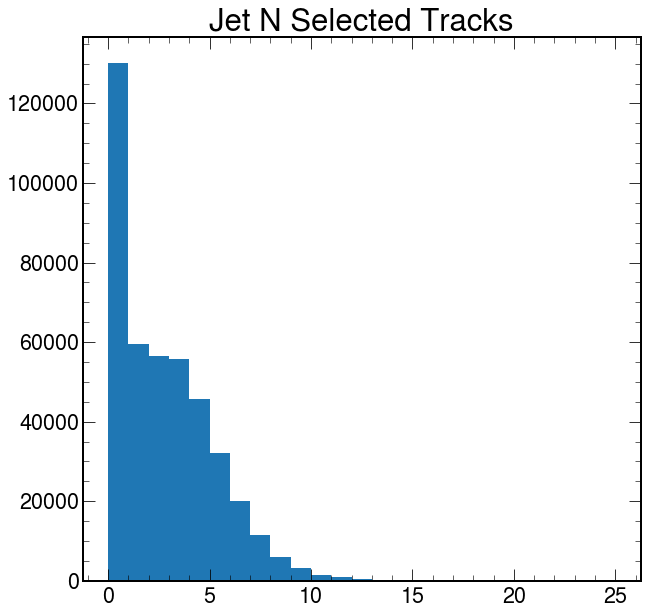

In [11]:
plt.hist(ar, bins=np.arange(26))
plt.title('Jet N Selected Tracks')

### Old way of cleaning files

In [12]:
def cleandataset(f):
# the feature-names are the attributes or columns of interest, in this case: information about Jets
    feature_names = [k for k in f['Events'].keys() if  (('Jet_eta' == k) or ('Jet_pt' == k) or ('Jet_DeepCSV' in k))]
    # tagger output to compare with later and variables used to get the truth output
    feature_names.extend(('Jet_btagDeepB_b','Jet_btagDeepB_bb', 'Jet_btagDeepC','Jet_btagDeepL'))
    feature_names.extend(('Jet_nBHadrons', 'Jet_hadronFlavour'))
    
    
    # go through a specified number of events, and get the information (awkward-arrays) for the keys specified above
    for data in f['Events'].iterate(feature_names, step_size=f['Events'].num_entries, library='ak'):
        break
        
    
    # creating an array to store all the columns with their entries per jet, flatten per-event -> per-jet
    datacolumns = np.zeros((len(feature_names)+1, len(ak.flatten(data['Jet_pt'], axis=1))))
   

    for featureindex in range(len(feature_names)):
        a = ak.flatten(data[feature_names[featureindex]], axis=1) # flatten along first inside to get jets
        
        datacolumns[featureindex] = ak.to_numpy(a)


    nbhad = ak.to_numpy(ak.flatten(data['Jet_nBHadrons'], axis=1))
    hadflav = ak.to_numpy(ak.flatten(data['Jet_hadronFlavour'], axis=1))

    target_class = np.full_like(hadflav, 3)                                                      # udsg
    target_class = np.where(hadflav == 4, 2, target_class)                                       # c
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad > 1), 1, target_class)            # bb
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad <= 1), 0, target_class)           # b, lepb

   

    datacolumns[len(feature_names)] = ak.to_numpy(target_class) 

    datavectors = datacolumns.transpose()

    datavecak = ak.from_numpy(datavectors)
        
    datavecak = datavecak[datavecak[:, 3] != -999]
    
    datavecak = datavecak[datavecak[:, 67] >= 0.]
    datavecak = datavecak[datavecak[:, 67] <= 1.]
    datavecak = datavecak[datavecak[:, 68] >= 0.]
    datavecak = datavecak[datavecak[:, 68] <= 1.]
    datavecak = datavecak[datavecak[:, 69] >= 0.]
    datavecak = datavecak[datavecak[:, 69] <= 1.]
    datavecak = datavecak[datavecak[:, 70] >= 0.]
    datavecak = datavecak[datavecak[:, 70] <= 1.]

    for j in range(len(datavecak[0])):
        datavecak = datavecak[datavecak[:, j] != np.nan]
        datavecak = datavecak[datavecak[:, j] > -np.inf]
        datavecak = datavecak[datavecak[:, j] < np.inf]

    # check jetNSelectedTracks, jetNSecondaryVertices > 0
    datavecak = datavecak[(datavecak[:, 63] > 0) | (datavecak[:, 64] > 0)]  # keep those where at least any of the two variables is > 0, they don't need to be > 0 simultaneously
    print(len(datavecak),"entries after removing jetNSelectedTracks and jetNSecondaryVertices = 0 at the same time")

    alldata = ak.to_numpy(datavecak)
    
    datacls = [i for i in range(0,67)]
    datacls.append(73)
    dataset = alldata[:, datacls]
    
    DeepCSV_dataset = alldata[:, 67:71]
    
    return dataset, DeepCSV_dataset

In [13]:
for n in range(len(rootfiles)):
    biggerdataset, biggerDeepCSV_dataset = cleandataset(rootfiles[n])
    np.save(f'/home/um106329/aisafety/information_datasets/tttosemilep_dataset_partially_clean_{n}.npy', biggerdataset)  
    np.save(f'/home/um106329/aisafety/information_datasets/tttosemilep_DeepCSV_dataset_partially_clean_{n}.npy', biggerDeepCSV_dataset)

90284 entries after removing jetNSelectedTracks and jetNSecondaryVertices = 0 at the same time


In [14]:
jetNselectedTracks_partially_clean = np.load('/home/um106329/aisafety/information_datasets/tttosemilep_dataset_partially_clean_0.npy')[:,64]

Text(0.5, 1.0, 'Jet N Selected Tracks')

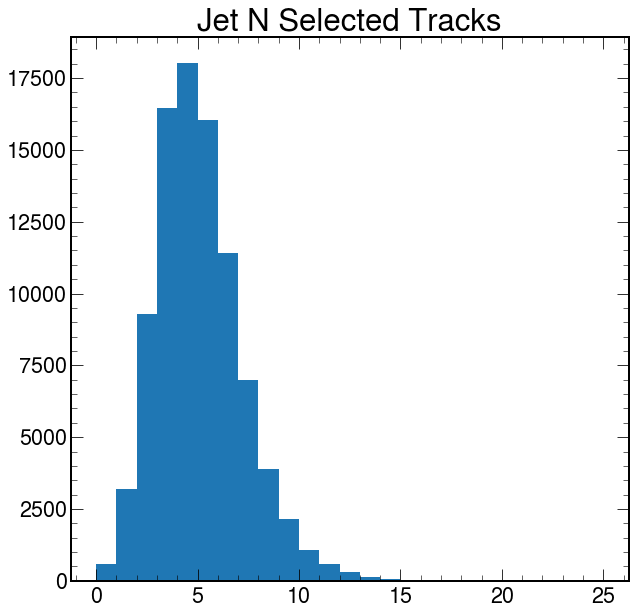

In [15]:
plt.hist(jetNselectedTracks_partially_clean, bins=np.arange(26))
plt.title('Jet N Selected Tracks')

### Part 2 of the file cleaning...
...was done because we thought one could get rid of the very large or weird values for certain track variables.

And this is now the step where the bin really disappears, though I just don't understand why cutting off large values could affect this one bin of five selected tracks??

In [16]:
def cleandataset_part_2(data, DeepCSV):
    
    for j in range(len(data[0])):
        DeepCSV = DeepCSV[data[:, j] > -999]
        data = data[data[:, j] > -999]
        DeepCSV = DeepCSV[data[:, j] <= 1000]
        data = data[data[:, j] <= 1000]
    
    return data, DeepCSV


In [19]:
dataset_paths = [f'/home/um106329/aisafety/information_datasets/tttosemilep_dataset_partially_clean_{n}.npy' for n in range(0, NUM_DATASETS)]
DeepCSV_paths = [f'/home/um106329/aisafety/information_datasets/tttosemilep_DeepCSV_dataset_partially_clean_{n}.npy' for n in range(0, NUM_DATASETS)]

In [20]:
for n in range(len(rootfiles)):
    biggerdataset, biggerDeepCSV_dataset = np.load(dataset_paths[n]), np.load(DeepCSV_paths[n])
    lenbiggerdata = len(biggerdataset)
    print(f'Length dataset {n} before deleting large / default values: {lenbiggerdata}')
    
    dataset, DeepCSV_dataset = cleandataset_part_2(biggerdataset, biggerDeepCSV_dataset)
    lendata = len(dataset)
    print(f'Length  {n}th dataset after deleting large / default values: {lendata}')
    
    del biggerdataset
    del biggerDeepCSV_dataset
    
    np.save(f'/home/um106329/aisafety/information_datasets/tttosemilep_dataset_clean_{n}.npy', dataset)  
    np.save(f'/home/um106329/aisafety/information_datasets/tttosemilep_DeepCSV_dataset_clean_{n}.npy', DeepCSV_dataset)  
    
    gc.collect()


Length dataset 0 before deleting large / default values: 90284
Length  0th dataset after deleting large / default values: 65538


In [21]:
jetNselectedTracks = np.load('/home/um106329/aisafety/information_datasets/tttosemilep_dataset_clean_0.npy')[:,64]

Text(0.5, 1.0, 'Jet N Selected Tracks')

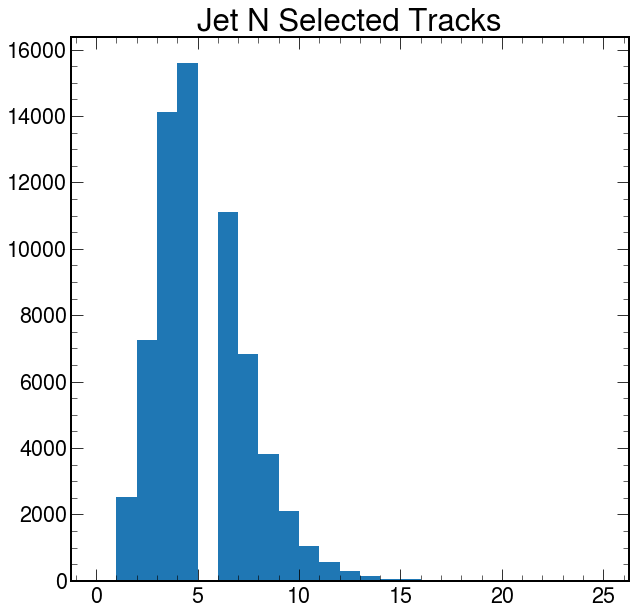

In [22]:
plt.hist(jetNselectedTracks, bins=np.arange(26))
plt.title('Jet N Selected Tracks')

So I think that from now on I will stop right after step 1 of the cleaning, and change step 2 to the method we discussed lately (using Jet N Selected Tracks as the filter for all the nonsense track values and replacing these with defaults). The good news is that the partially cleaned datasets are not gone, just the raw .root files used to get them are not accessible anymore.